This notebook shows the analysis for section Case Studies

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import glob
from xscen.config import CONFIG, load_config
import cartopy.crs as ccrs
import pandas as pd
from matplotlib import pyplot as plt
import xclim as xc
import numpy as np
import datetime
from matplotlib.dates import DateFormatter
import scipy
from matplotlib.offsetbox import AnchoredText
from textwrap import wrap
from dask.distributed import Client
from matplotlib.pyplot import cm
import spirograph.matplotlib as sp
from string import ascii_lowercase
sp.utils.set_mpl_style('ouranos')

import xscen as xs
from dask.diagnostics import ProgressBar
load_config('paths_pc.yml', verbose=(__name__ == '__main__'), reset=True)
tdd={'xarray_open_kwargs':{'decode_timedelta': False}}

pcat = xs.ProjectCatalog(CONFIG['paths']['project_catalog'])
pcat_espo = xs.ProjectCatalog(CONFIG['paths']['pcat_espo'])


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


INFO:xscen.config:Updated the config with paths_pc.yml.


# timeserie plot

In [13]:
plot_kw={'PC':{'color':'blue'}, 'CDCA':{'color':'red'}}
exp_def={'Moderate Emissions':{'PC':'ssp245', 'CDCA':'ssp245'},'High Emissions':{'PC':'ssp370', 'CDCA':'ssp585'}}
sources_hausfather= ['MIROC6','CMCC-ESM2', 'FGOALS-g3', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'INM-CM5-0',
 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'KACE-1-0-G', 'CNRM-ESM2-1', 'GFDL-ESM4', 'BCC-CSM2-MR']

def get_pvalue(group1, group2 ):
    
    # check if they have the same variance, F-test
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = len(group1)-1
    dun = len(group2)-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)
    if p_value >= 0.05:
        equal_var=  True 
    else:
        equal_var = False 
    
    # T-test
    pvalue=scipy.stats.ttest_ind(group1,group2, equal_var =equal_var , nan_policy='omit').pvalue
    
    return pvalue

def violin(ax, group1, group2, xticks=["",""], xlabel="", ylabel="", title=""):
    
    
    parts=ax.violinplot([group1],positions=[1],showmeans=True)
    parts2=ax.violinplot([ group2],positions=[2],showmeans=True)
    def set_axis_style(ax, xticks):
        ax.set_xticks(np.arange(1, len(xticks) + 1), labels=xticks)
        ax.set_xlim(0.25, len(xticks) + 0.75)
    set_axis_style(ax, xticks)

    for pc in parts['bodies']:
        pc.set_facecolor('b')
        pc.set_alpha(0.2)
    for pc in parts2['bodies']:
        pc.set_facecolor('r')
        pc.set_alpha(0.2)
    for partname in ('cbars','cmins','cmaxes','cmeans'):#'cmedians'):
        vp = parts2[partname]
        vp.set_edgecolor('r')
        vp = parts[partname]
        vp.set_edgecolor('b')

    maxi=np.max([ax.get_ylim()[1]])
    pvalue=get_pvalue(group1, group2)
    
    #ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_title(f"{title} \n (p =  %.4f)" % pvalue, fontsize=14)
    ax.set_ylabel(ylabel.replace(':', ': \n'), fontsize=10)
    return ax

    
    
def cs_plot(var_pc, var_cd, xrfreq,  lat, lon, restrict_month=False, convert_units=False,
            ylabel=None, delta_ylabel=None ):

    big_fig= plt.figure(figsize=(15,13),constrained_layout=True)

    figs=big_fig.subfigures(nrows=2,ncols=1, hspace=0.1)
    axs=[]
    for i,experiment in enumerate(['Moderate Emissions','High Emissions']):
        
        fig=figs[i]
        ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3,
                                   gridspec_kw={'width_ratios': [7, 1, 1]},
                                  )
        

        ax1.get_shared_y_axes().join(ax1, ax2)
        # portraits climatiques
        ds_pc = pcat_espo.search(processing_level='ensemble-indicators',
                                 bias_adjust_project='ESPO-G6',
                                 experiment=exp_def[experiment]['PC'],
                                 domain='NAM-rdrs',
                                variable = [var_pc+p for p in ['_p10','_p50','_p90']],
                                xrfreq=xrfreq,
                            ).to_dask(**tdd)
        # select lat lon on rlat rlon
        ds_pc = xs.spatial.subset(ds_pc,region=dict(method='gridpoint',
                                                    name='single_point',
                                                    gridpoint =dict(lat=[lat], lon=[lon])))
        #climate data
        ds_cd = pcat.search(processing_level='ensemble-indicators',
                            bias_adjust_project='climatedata',
                            experiment=exp_def[experiment]['CDCA'],
                            variable = [var_cd+p for p in ['_p10','_p50','_p90']],
                            xrfreq=xrfreq,

                   ).to_dask(**tdd).sel(lat=lat, lon=lon, method='nearest')


        if restrict_month:
            ds_pc = ds_pc.sel(time=ds_pc.time.dt.month.isin(restrict_month))
            ds_cd = ds_cd.sel(time=ds_cd.time.dt.month.isin(restrict_month))

        # convert units
        if convert_units:
            for var in ds_pc.data_vars:
                ds_pc[var] = xc.units.convert_units_to(ds_pc[var], convert_units)
            for var in ds_cd.data_vars:
                ds_cd[var] = xc.units.convert_units_to(ds_cd[var], convert_units)

        
            
        #time series
        sp.timeseries({'PC':ds_pc, 'CDCA':ds_cd},ax=ax1,plot_kw=plot_kw, legend='edge')
        ax1.axvline(np.datetime64('2015-01-01'), color='grey', linestyle=':')
        
        ax1.set_title(f"", loc='left')
            
        ylabel= ylabel or ax1.get_ylabel()
        ax1.set_ylabel(ylabel)
        title=ylabel.split(' (')[0].replace('\n', ' ')
        ax1.set_title(f"{ascii_lowercase[(i*3)]}) {title}", y =1.05)

        # median significance
        ds_pc_median = ds_pc.sel(time=slice('2071','2100'))[f"{var_pc}_p50"].values
        ds_cd_median = ds_cd.sel(time=slice('2071','2100'))[f"{var_cd}_p50"].values
        violin(ax2, ds_pc_median,ds_cd_median,xticks=['', ''], xlabel='2071-2100',
               title=f'{ascii_lowercase[(i*3)+1]}) Value')


        # delta significance
        # portraits
        ds_pc = pcat_espo.search(processing_level='abs-delta-1991-2020',
                                 bias_adjust_project='ESPO-G6',
                                 experiment=exp_def[experiment]['PC'],
                                 variable = f"{var_pc}_delta_1991_2020",
                                 domain='NAM-rdrs',
                                 source=sources_hausfather,
                                 xrfreq=xrfreq,
                            ).to_dataset_dict(**tdd)

        #climate data
        ds_cd = pcat.search(processing_level=['30ymean','abs-delta'],
                            bias_adjust_project='climatedata',
                            experiment=exp_def[experiment]['CDCA'],
                            variable = f"{var_cd}_delta_1991_2020",
                            xrfreq=xrfreq,
                   ).to_dataset_dict(**tdd)


        ds_pc_delta = [xs.spatial.subset(ds[f"{var_pc}_delta_1991_2020"],
                                         region=dict(method='gridpoint',
                                                     name='single_point',
                                                     gridpoint =dict(lat=[lat], lon=[lon]))).sel(time='2071').values[0]
                       for i,ds in ds_pc.items()]

        ds_cd_delta = [ds[f'{var_cd}_delta_1991_2020'].sel(lat=lat, lon=lon, method='nearest').sel(time='2071').values[0] for i,ds in ds_cd.items()]


        print('Number of PC delta < 0')
        print(len([x for x in ds_pc_delta if x<0]))
        print('Number of CD delta < 0')
        print(len([x for x in ds_cd_delta if x<0]))
        

        delta_ylabel=delta_ylabel or f"{ds_pc.popitem()[1][f'{var_pc}_delta_1991_2020'].attrs['long_name']} ({ds_pc.popitem()[1][f'{var_pc}_delta_1991_2020'].attrs['units']})"
        violin(ax3, ds_pc_delta,ds_cd_delta,xticks=['', ''], xlabel='2071-2100',
               title=f'{ascii_lowercase[(i*3)+2]}) Change',ylabel=delta_ylabel)
        
        

        fig.suptitle(experiment, fontsize=25)
        #fig.tight_layout()
        axs.append([ax1, ax2, ax3])
    return figs,axs

# 5 chosen

## 1. Ice Roads

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "units" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

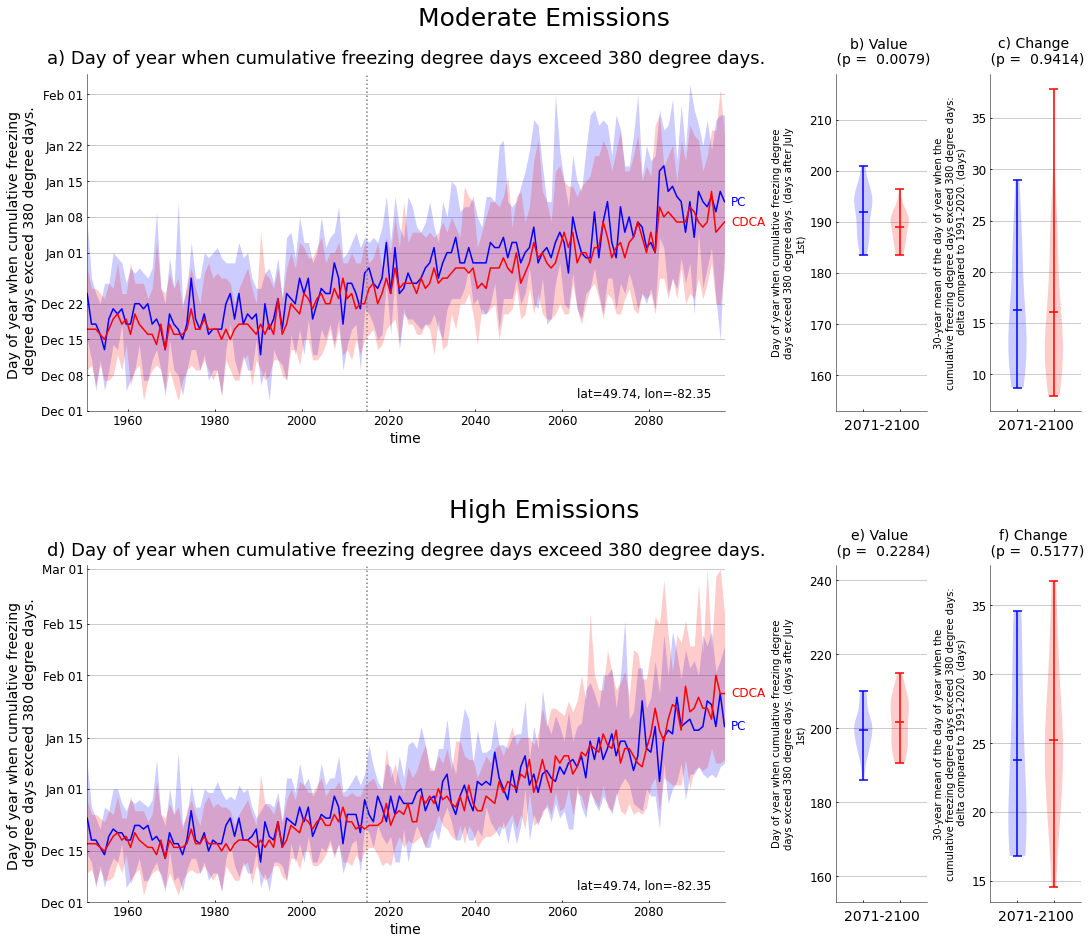

In [5]:
var_pc= 'fdd_380'
var_cd= 'fdd_380'
xrfreq='AS-JUL'
 
lat, lon = 49.7189, -82.3562 # Kapuskasing Community, Ontario

big_fig= plt.figure(figsize=(15,13),constrained_layout=True)

figs=big_fig.subfigures(nrows=2,ncols=1, hspace=0.1)
axs=[]
for i,exp_title in enumerate(['Moderate Emissions','High Emissions']):
    fig=figs[i]
    ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3,
                               gridspec_kw={'width_ratios': [7, 1, 1]},
                              )
    ds_pc = pcat_espo.search(processing_level='ensemble-indicators',
                             bias_adjust_project='ESPO-G6',
                             experiment=exp_def[exp_title]['PC'],
                             domain='NAM-rdrs',
                             variable = [var_pc+p for p in ['_p10','_p50','_p90']],
                             xrfreq=xrfreq,
                        ).to_dask(**tdd).sel(time=slice('1950','2097'))

    ds_pc = xs.spatial.subset(ds_pc,region=dict(method='gridpoint',
                                                    name='single_point',
                                                    gridpoint =dict(lat=[lat], lon=[lon])))

    #climate data
    ds_cd = pcat.search(processing_level='ensemble-indicators',
                        bias_adjust_project='climatedata',
                        experiment=exp_def[exp_title]['CDCA'],
                        variable = [var_cd+p for p in ['_p10','_p50','_p90']],
                        xrfreq=xrfreq,
               ).to_dask(**tdd).sel(lat=lat, lon=lon, method='nearest').sel(time=slice('1950','2097'))

    ds_pc_drop=ds_pc.dropna(dim='time')
    ds_cd_drop=ds_cd.dropna(dim='time')

    # transform days_since 01-07 to date
    date_vars=[]
    for var in ds_pc.data_vars:
        pc_format=xr.DataArray(data=np.array([datetime.timedelta(x) + datetime.date(2007,7,1)
                                     for x,t in zip(ds_pc_drop[var].values,ds_pc_drop['time'].values) ]),
                               dims=['time'])
        ds_pc_drop=ds_pc_drop.assign(**{f"DATE_{var}" :pc_format})
        #ds_pc_drop=ds_pc_drop.drop_vars(var)

        cd_format=xr.DataArray(data=np.array([datetime.timedelta(x) + datetime.date(2007,7,1)
                                     for x,t in zip(ds_cd_drop[var].values,ds_cd_drop['time'].values) ]),
                               dims=['time'])
        ds_cd_drop=ds_cd_drop.assign(**{f"DATE_{var}" :cd_format})
        date_vars.append(f"DATE_{var}")


    sp.timeseries({'PC':ds_pc_drop[date_vars], 'CDCA':ds_cd_drop[date_vars]},ax=ax1,plot_kw=plot_kw, legend='edge')



    date_form = DateFormatter("%b %d")
    if exp_title == 'Moderate Emissions':
        ax1.set_ylim((np.datetime64('2007-12-01'), np.datetime64('2008-02-05')))
    else:
        ax1.set_ylim((np.datetime64('2007-12-01'), np.datetime64('2008-03-02')))

    ax1.yaxis.set_major_formatter(date_form)
    ax1.axvline(np.datetime64('2015-01-01'), color='grey', linestyle=':')
    ax1.set_ylabel('Day of year when cumulative freezing \n degree days exceed 380 degree days.')
    #ax1.set_title(f"lat = {lat:.2f}, lon = {lon:.2f}")
    ax1.set_title(f"{ascii_lowercase[(i*3)]}) Day of year when cumulative freezing degree days exceed 380 degree days.")



    # # plot violin
    ds_pc_median = ds_pc_drop.sel(time=slice('2070','2099'))[f"{var_pc}_p50"].values
    ds_cd_median = ds_cd_drop.sel(time=slice('2070','2099'))[f"{var_cd}_p50"].values
    violin(ax2, ds_pc_median,ds_cd_median,xticks=['', ''], xlabel='2071-2100',title=f'{ascii_lowercase[(i*3)+1]}) Value')
    if exp_title == 'Moderate Emissions':
        ax2.set_ylim(153,219)
    else:
        ax2.set_ylim(153,244)
    ax2.set_ylabel('\n'.join(wrap('Day of year when cumulative freezing degree days exceed 380 degree days. (days after July 1st)', 45)))


    # delta significance
    # portraits
    ds_pc = pcat_espo.search(processing_level=['abs-delta-1991-2020','abs-delta'],
                             bias_adjust_project='ESPO-G6',
                             experiment=exp_def[exp_title]['PC'],domain='NAM-rdrs',
                             variable = f"{var_pc}_delta_1991_2020",xrfreq='AS-JUL').to_dataset_dict(**tdd)

    #climate data
    ds_cd = pcat.search(processing_level='abs-delta',bias_adjust_project='climatedata',
                        experiment=exp_def[exp_title]['CDCA'],variable = f"{var_cd}_delta_1991_2020",
                        xrfreq='AS-JUL').to_dataset_dict(**tdd)


    ds_pc_delta = [float(xs.spatial.subset(ds[f"{var_pc}_delta_1991_2020"],region=dict(method='gridpoint',
                                                    name='single_point',
                                                    gridpoint =dict(lat=[lat], lon=[lon]))).sel(
        time='2071').values) for i,ds in ds_pc.items()]



    ds_cd_delta = [float(ds[f'{var_cd}_delta_1991_2020'].sel(lat=lat, lon=lon, method='nearest').sel(
        time='2071').values) for i,ds in ds_cd.items()]
    
    # remove nan
    ds_pc_delta= [x for x in ds_pc_delta if not np.isnan(x)]
    ds_cd_delta= [x for x in ds_cd_delta if not np.isnan(x)]
    
    violin(ax3, ds_pc_delta,ds_cd_delta,xticks=['', ''], xlabel='2071-2100',title=f'{ascii_lowercase[(i*3)+2]}) Change',
           ylabel=f"{ds_pc.popitem()[1][f'{var_pc}_delta_1991_2020'].attrs['long_name']} (days)")

    ax3.set_ylabel('30-year mean of the day of year when the\n cumulative freezing degree days exceed 380 degree days: \n delta compared to 1991-2020. (days)')
    fig.suptitle(exp_title, fontsize=25)
plt.savefig(f"{CONFIG['paths']['figures']}freezeup_nan.pdf", bbox_inches='tight')

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "description" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "units" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

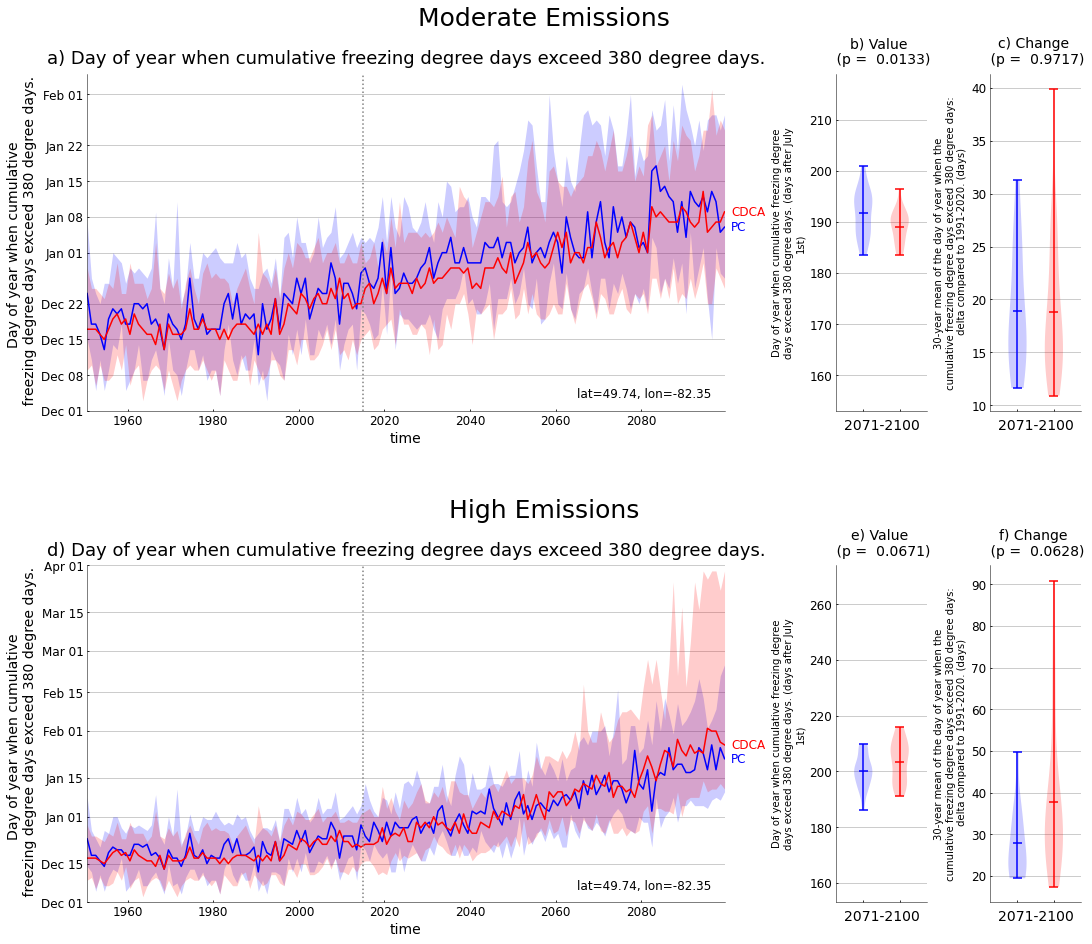

In [6]:
# change nan in march 31st
var_pc= 'fdd_380_273'
var_cd= 'fdd_380_273'
xrfreq='AS-JUL'
 
lat, lon = 49.7189, -82.3562 # Kapuskasing Community, Ontario
big_fig= plt.figure(figsize=(15,13),constrained_layout=True)

figs=big_fig.subfigures(nrows=2,ncols=1, hspace=0.1)
axs=[]
for i, exp_title in enumerate(['Moderate Emissions','High Emissions']):

    fig=figs[i]
    ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3,
                               gridspec_kw={'width_ratios': [7, 1, 1]},
                              )
    ds_pc = pcat_espo.search(processing_level='ensemble-indicators',
                             bias_adjust_project='ESPO-G6',
                             experiment=exp_def[exp_title]['PC'],
                             domain='NAM-rdrs',
                             variable = [var_pc+p for p in ['_p10','_p50','_p90']],
                             xrfreq=xrfreq,
                        ).to_dask(**tdd).sel(time=slice('1950','2099'))
    
    ds_pc = xs.spatial.subset(ds_pc,region=dict(method='gridpoint',
                                                    name='single_point',
                                                    gridpoint =dict(lat=[lat], lon=[lon])))

    #climate data
    ds_cd = pcat.search(processing_level='ensemble-indicators',
                        bias_adjust_project='climatedata',
                        experiment=exp_def[exp_title]['CDCA'],
                        variable = [var_cd+p for p in ['_p10','_p50','_p90']],
                        xrfreq=xrfreq,
               ).to_dask(**tdd).sel(lat=lat, lon=lon, method='nearest').sel(time=slice('1950','2099'))

    ds_pc_drop=ds_pc.dropna(dim='time')
    ds_cd_drop=ds_cd.dropna(dim='time')

    # transform days_since 01-07 to date
    date_vars=[]
    for var in ds_pc.data_vars:
        pc_format=xr.DataArray(data=np.array([datetime.timedelta(x) + datetime.date(2007,7,1)
                                     for x,t in zip(ds_pc_drop[var].values,ds_pc_drop['time'].values) ]),
                               dims=['time'])
        ds_pc_drop=ds_pc_drop.assign(**{f"DATE_{var}" :pc_format})
        #ds_pc_drop=ds_pc_drop.drop_vars(var)

        cd_format=xr.DataArray(data=np.array([datetime.timedelta(x) + datetime.date(2007,7,1)
                                     for x,t in zip(ds_cd_drop[var].values,ds_cd_drop['time'].values) ]),
                               dims=['time'])
        ds_cd_drop=ds_cd_drop.assign(**{f"DATE_{var}" :cd_format})
        date_vars.append(f"DATE_{var}")


    sp.timeseries({'PC':ds_pc_drop[date_vars], 'CDCA':ds_cd_drop[date_vars]},ax=ax1,plot_kw=plot_kw, legend='edge')



    date_form = DateFormatter("%b %d")
    if exp_title == 'Moderate Emissions':
        ax1.set_ylim((np.datetime64('2007-12-01'), np.datetime64('2008-02-05')))
    else:
        ax1.set_ylim((np.datetime64('2007-12-01'), np.datetime64('2008-04-01')))
    ax1.yaxis.set_major_formatter(date_form)
    ax1.axvline(np.datetime64('2015-01-01'), color='grey', linestyle=':')
    ax1.set_ylabel('Day of year when cumulative \n freezing degree days exceed 380 degree days.')
    #ax1.set_title(f"lat = {lat:.2f}, lon = {lon:.2f}")
    ax1.set_title(f"{ascii_lowercase[(i*3)]}) Day of year when cumulative freezing degree days exceed 380 degree days.")



    # # plot violin
    ds_pc_median = ds_pc_drop.sel(time=slice('2070','2099'))[f"{var_pc}_p50"].values
    ds_cd_median = ds_cd_drop.sel(time=slice('2070','2099'))[f"{var_cd}_p50"].values
    violin(ax2, ds_pc_median,ds_cd_median,xticks=['', ''], xlabel='2071-2100',
           title=f'{ascii_lowercase[(i*3)+1]}) Value')
    if exp_title == 'Moderate Emissions':
        ax2.set_ylim(153,219)
    else:
        ax2.set_ylim(153,274)
    ax2.set_ylabel('\n'.join(wrap('Day of year when cumulative freezing degree days exceed 380 degree days. (days after July 1st)', 45)))


    # delta significance
    # portraits
    ds_pc = pcat_espo.search(processing_level=['abs-delta-1991-2020'],
                             bias_adjust_project='ESPO-G6',
                             experiment=exp_def[exp_title]['PC'],domain='NAM-rdrs',
                             variable = f"{var_pc}_delta_1991_2020",xrfreq='AS-JUL').to_dataset_dict(**tdd)

    #climate data
    ds_cd = pcat.search(processing_level='abs-delta',bias_adjust_project='climatedata',
                        experiment=exp_def[exp_title]['CDCA'],variable = f"{var_cd}_delta_1991_2020",
                        xrfreq='AS-JUL').to_dataset_dict(**tdd)


    ds_pc_delta = [float(xs.spatial.subset(ds[f"{var_pc}_delta_1991_2020"],region=dict(method='gridpoint',
                                                    name='single_point',
                                                    gridpoint =dict(lat=[lat], lon=[lon]))).sel(
        time='2071').values) for i,ds in ds_pc.items()]



    ds_cd_delta = [float(ds[f'{var_cd}_delta_1991_2020'].sel(lat=lat, lon=lon, method='nearest').sel(
        time='2071').values) for i,ds in ds_cd.items()]
    
    # remove nan
    ds_pc_delta= [x for x in ds_pc_delta if not np.isnan(x)]
    ds_cd_delta= [x for x in ds_cd_delta if not np.isnan(x)]
    
    violin(ax3, ds_pc_delta,ds_cd_delta,xticks=['', ''], xlabel='2071-2100',
           title=f'{ascii_lowercase[(i*3)+2]}) Change',
           ylabel=f"{ds_pc.popitem()[1][f'{var_pc}_delta_1991_2020'].attrs['long_name']} (days)")

    ax3.set_ylabel('30-year mean of the day of year when the\n cumulative freezing degree days exceed 380 degree days: \n delta compared to 1991-2020. (days)')
    fig.suptitle(exp_title, fontsize=25)
plt.savefig(f"{CONFIG['paths']['figures']}freezeup_273.pdf", bbox_inches='tight')

## 2. Metrolinx

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
11
Number of CD delta < 0
26


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
13
Number of CD delta < 0
26


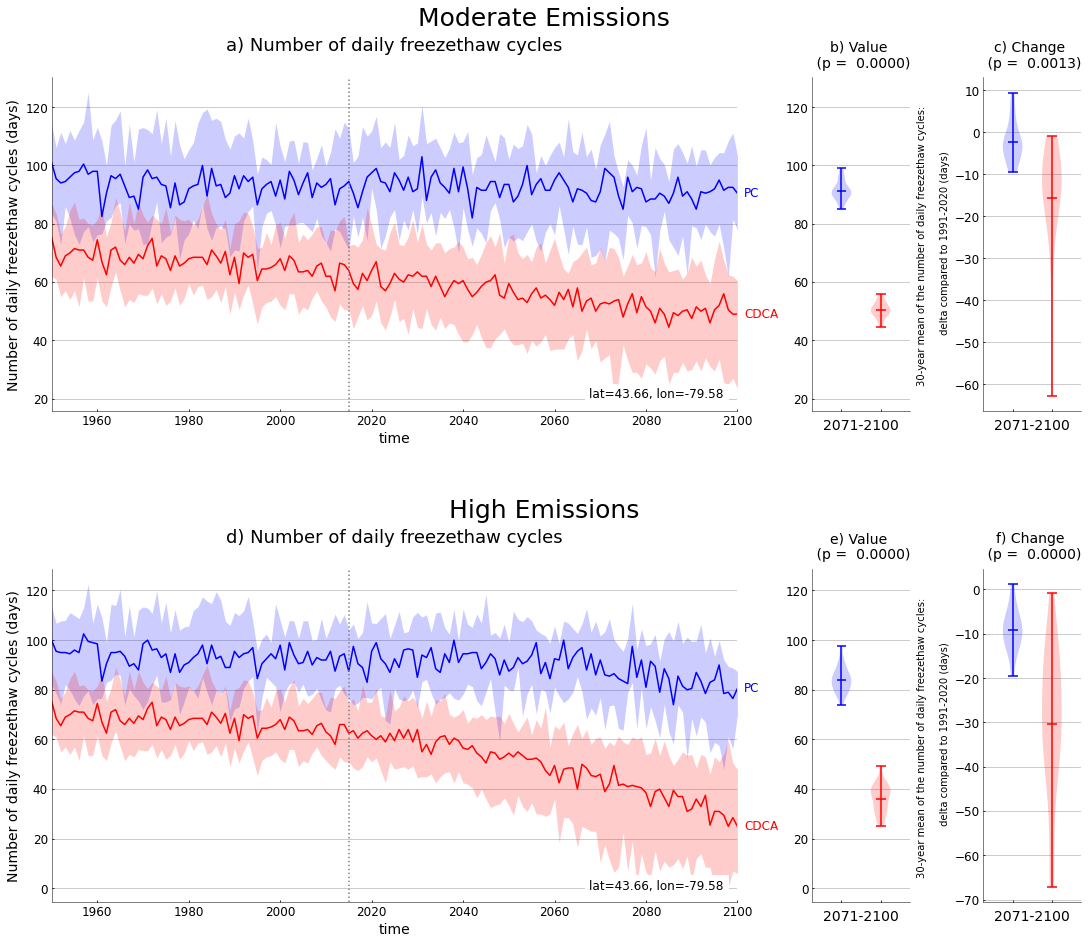

In [7]:
fig,axs= cs_plot(
    var_pc='dlyfrzthw', var_cd='dlyfrzthw_tx0_tn-1', # these are the indicators on the websites
    xrfreq='AS-JAN',
    lat=43.6777, lon= -79.6248, # Toronto,
    ylabel='Number of daily freezethaw cycles (days)',
    delta_ylabel='30-year mean of the number of daily freezethaw cycles:\n delta compared to 1991-2020 (days)'
                   )
plt.savefig(f"{CONFIG['paths']['figures']}cycles_diff.pdf", bbox_inches='tight')

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
11
Number of CD delta < 0
26


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
13
Number of CD delta < 0
26


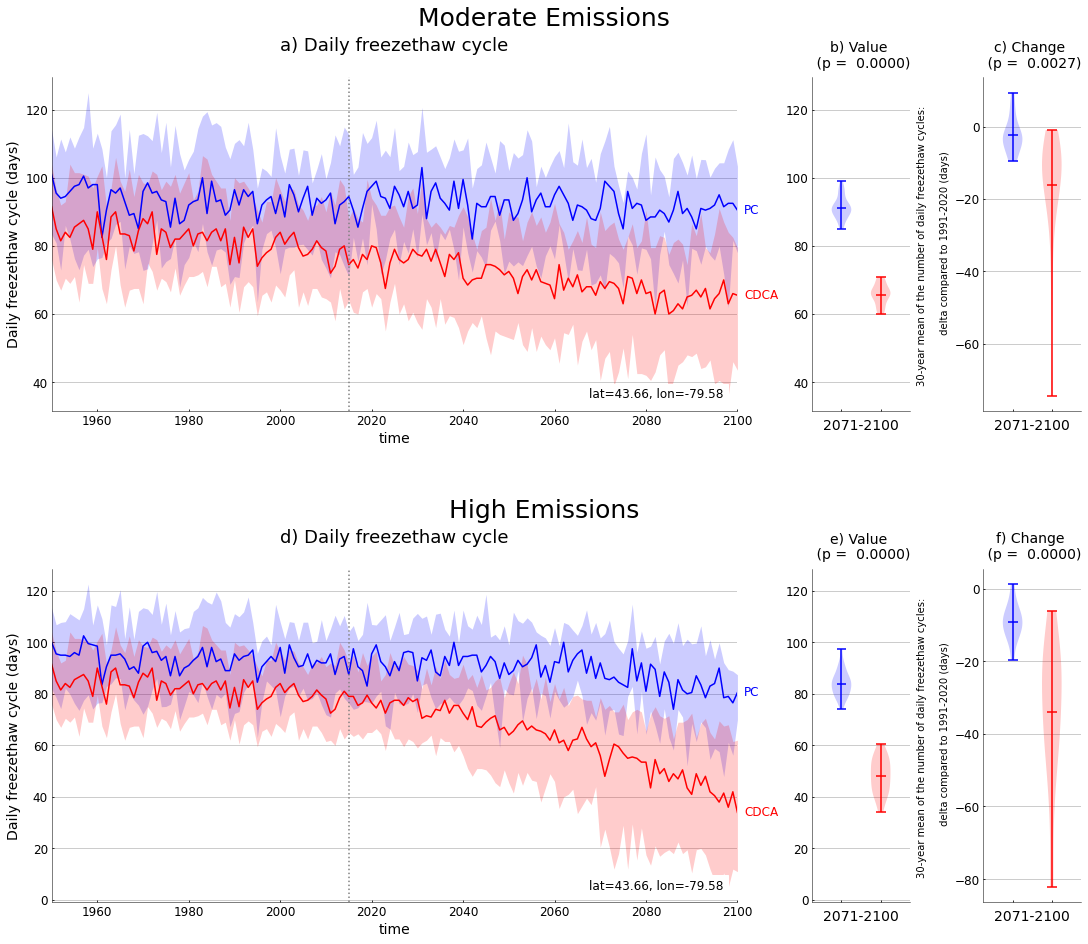

In [8]:
fig,axs= cs_plot(
    var_pc='dlyfrzthw', var_cd='dlyfrzthw',# this one was recalculates to check with exact same indicator
    xrfreq='AS-JAN',
    lat=43.6777, lon= -79.6248, # Toronto
    ylabel='Daily freezethaw cycle (days)',
    delta_ylabel='30-year mean of the number of daily freezethaw cycles:\n delta compared to 1991-2020 (days)'
                   )
plt.savefig(f"{CONFIG['paths']['figures']}cycles_same.pdf", bbox_inches='tight')

## 3. Wine

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
0


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
0


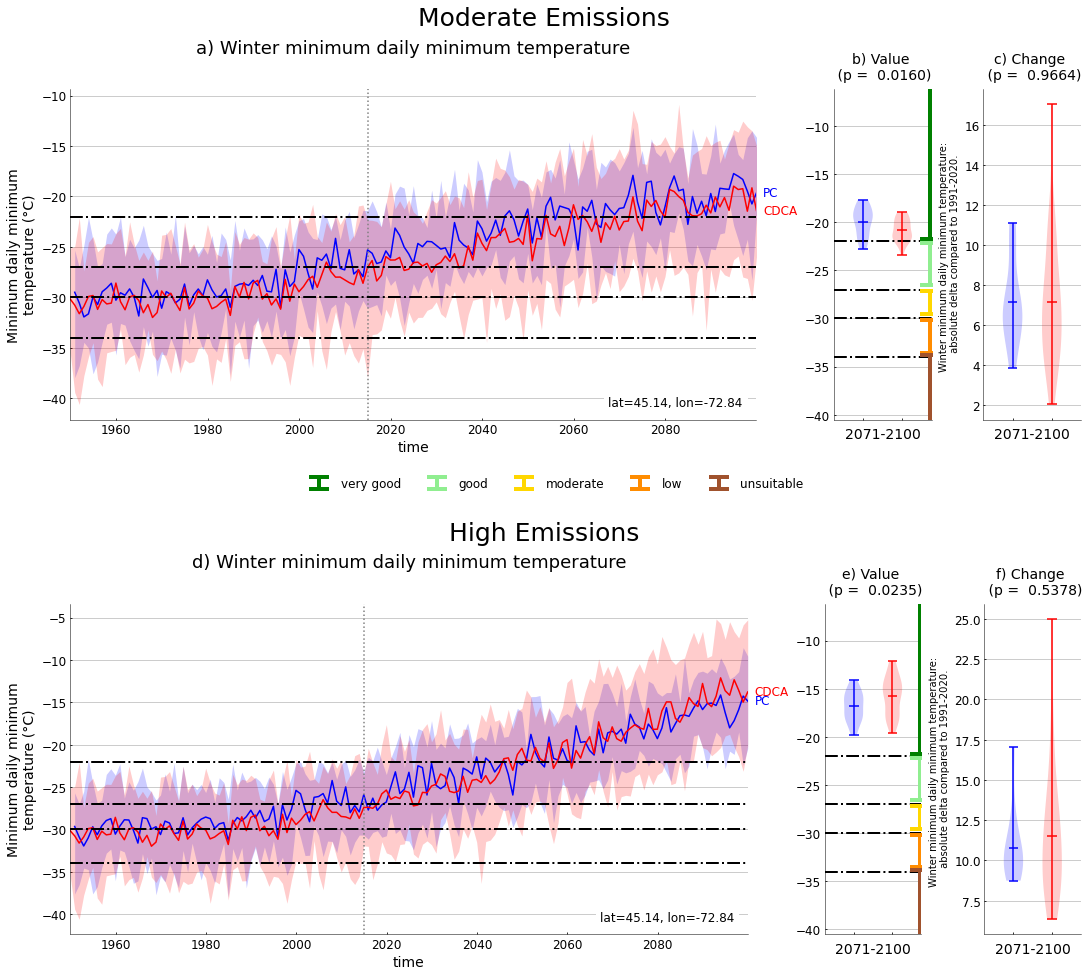

In [9]:

var_pc='tn_min'
var_cd='tn_min' # change for min
xrfreq=['QS-DEC','MS']

lat= 45.133331
lon= -72.800003 # Dunham
restrict_month= [12], # restrict to DJF
convert_units= 'degC'
                   
big_fig= plt.figure(figsize=(15,13),constrained_layout=True)

figs=big_fig.subfigures(nrows=2,ncols=1, hspace=0.2)
axs=[]
for i,exp_title in enumerate(['Moderate Emissions','High Emissions']):

    fig=figs[i]
    ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3,
                               gridspec_kw={'width_ratios': [7, 1, 1]},
                              )

    # portraits climatiques
    ds_pc = pcat_espo.search(processing_level='ensemble-indicators',
                             bias_adjust_project='ESPO-G6',
                             experiment=exp_def[exp_title]['PC'],
                            variable = [var_pc+p for p in ['_p10','_p50','_p90']],
                            xrfreq='QS-DEC',
                        ).to_dask(**tdd).sel(time=slice(None,'2099')) # no DJF 2100
    ds_pc = xs.spatial.subset(ds_pc,region=dict(method='gridpoint',
                                           name='single_point',
                                           gridpoint =dict(lat=[lat], lon=[lon])))

    #climate data
    ds_cd = pcat.search(processing_level='ensemble-indicators',
                        bias_adjust_project='climatedata',
                        experiment=exp_def[exp_title]['CDCA'],
                        variable = [var_cd+p for p in ['_p10','_p50','_p90']],
                        xrfreq='MS',

               ).to_dask(**tdd).sel(lat=lat, lon=lon, method='nearest')
    # resample in QS-DEC
    ds_cd= ds_cd.resample(time='QS-DEC').min(keep_attrs=True).sel(time=slice(None,'2099'))

    if restrict_month:
        ds_pc = ds_pc.sel(time=ds_pc.time.dt.month.isin(restrict_month))
        ds_cd = ds_cd.sel(time=ds_cd.time.dt.month.isin(restrict_month))



    # convert units
    if convert_units:
        for var in ds_pc.data_vars:
            ds_pc[var] = xc.units.convert_units_to(ds_pc[var], convert_units)
        for var in ds_cd.data_vars:
            ds_cd[var] = xc.units.convert_units_to(ds_cd[var], convert_units)



    ds_pc.attrs['long_name']= "Winter minimum daily minimum temperature"

    #time series
    sp.timeseries({'PC':ds_pc, 'CDCA':ds_cd},ax=ax1,plot_kw=plot_kw, legend='edge')
    ax1.axvline(np.datetime64('2015-01-01'), color='grey', linestyle=':')
    ax1.set_title(f"{ascii_lowercase[(i*3)]}) Winter minimum daily minimum temperature", y =1.08)
    ax1.set_title(f"", loc='left')

    # plot  sections
    lw=2
    for ax in [ax1, ax2]:
        ax.axhline(-22, color='black', linestyle='-.', linewidth=lw)
        ax.axhline(-27, color='black', linestyle='-.', linewidth=lw)
        ax.axhline(-30, color='black', linestyle='-.', linewidth=lw)
        ax.axhline(-34, color='black', linestyle='-.', linewidth=lw)

    x_time=3

    x_error=2.7
    ct=4
    shift=0.15
    ew=4
    ax2.errorbar(x_error, -14 +shift,xerr=None,yerr=7.9,capsize=10, color='green',capthick=ct,elinewidth=ew,linestyle="None", label='very good')
    ax2.errorbar(x_error, -24.5+shift,xerr=None,yerr=2.2,capsize=10, color='lightgreen',capthick=ct,elinewidth=ew,linestyle="None", label='good')
    ax2.errorbar(x_error, -28.5+shift,xerr=None,yerr=1.2,capsize=10, color='gold',capthick=ct,elinewidth=ew,linestyle="None", label='moderate')
    ax2.errorbar(x_error, -32+shift,xerr=None,yerr=1.7,capsize=10, color='darkorange',capthick=ct,elinewidth=ew,linestyle="None", label='low')
    ax2.errorbar(x_error, -37.5+shift,xerr=None,yerr=3.5,capsize=10, color='sienna',capthick=ct,elinewidth=ew,linestyle="None", label='unsuitable')
    ax2.set_ylim(-40.5,-6.2)
    if i==1:
        handles, labels = ax2.get_legend_handles_labels()
        fig.legend(handles, labels, ncol=5, bbox_to_anchor=(0.75,1.2))


    # plot violin
    ds_pc_median = ds_pc.sel(time=slice('2071','2099'))[f"{var_pc}_p50"].values[:-1]
    ds_cd_median = ds_cd.sel(time=slice('2071','2099'))[f"{var_cd}_p50"].values
    violin(ax2, ds_pc_median,ds_cd_median,xticks=['', ''], xlabel='2071-2100',
           title=f'{ascii_lowercase[(i*3)+1]}) Value')


    # delta significance
    # portraits
    ds_pc = pcat_espo.search(processing_level='abs-delta-1991-2020',
                             bias_adjust_project='ESPO-G6',
                             experiment=exp_def[exp_title]['PC'],
                             source=sources_hausfather,
                            variable = f"{var_pc}_delta_1991_2020",
                            xrfreq='QS-DEC',
                        ).to_dataset_dict(**tdd)

    #climate data
    ds_cd = pcat.search(processing_level='30ymean',
                        bias_adjust_project='climatedata',
                        experiment=exp_def[exp_title]['CDCA'],
                        variable = f"{var_cd}_delta_1991_2020",
                        xrfreq='MS',
               ).to_dataset_dict(**tdd)
    # resample in QS-DEC
    ds_cd= {i:ds.resample(time='QS-DEC').min(keep_attrs=True) for i,ds in ds_cd.items()}

    ds_pc_delta = [float(xs.spatial.subset(ds[f"{var_pc}_delta_1991_2020"],
                                           region=dict(method='gridpoint',
                                           name='single_point',
                                           gridpoint =dict(lat=[lat], lon=[lon]))).sel(time='2071-12-01').values)
                   for i,ds in ds_pc.items()]
    ds_cd_delta = [float(ds[f'{var_cd}_delta_1991_2020'].sel(lat=lat, lon=lon, method='nearest').sel(time='2071-12-01').values)
                   for i,ds in ds_cd.items()]
    print('Number of PC delta < 0')
    print(len([x for x in ds_pc_delta if x<0]))
    print('Number of CD delta < 0')
    print(len([x for x in ds_cd_delta if x<0]))
    violin(ax3, ds_pc_delta,ds_cd_delta,xticks=['', ''], xlabel='2071-2100',
           title=f'{ascii_lowercase[(i*3)+2]}) Change',
           ylabel="Winter minimum daily minimum temperature: absolute delta compared to 1991-2020.")
    fig.suptitle(exp_title, y=1.07, fontsize=25)
plt.savefig(f"{CONFIG['paths']['figures']}wine.pdf", bbox_inches='tight')

## 4. Highways and rain

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
2


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
0


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.


BELLA COOLA  1060841 52.3875 -126.59583333333333


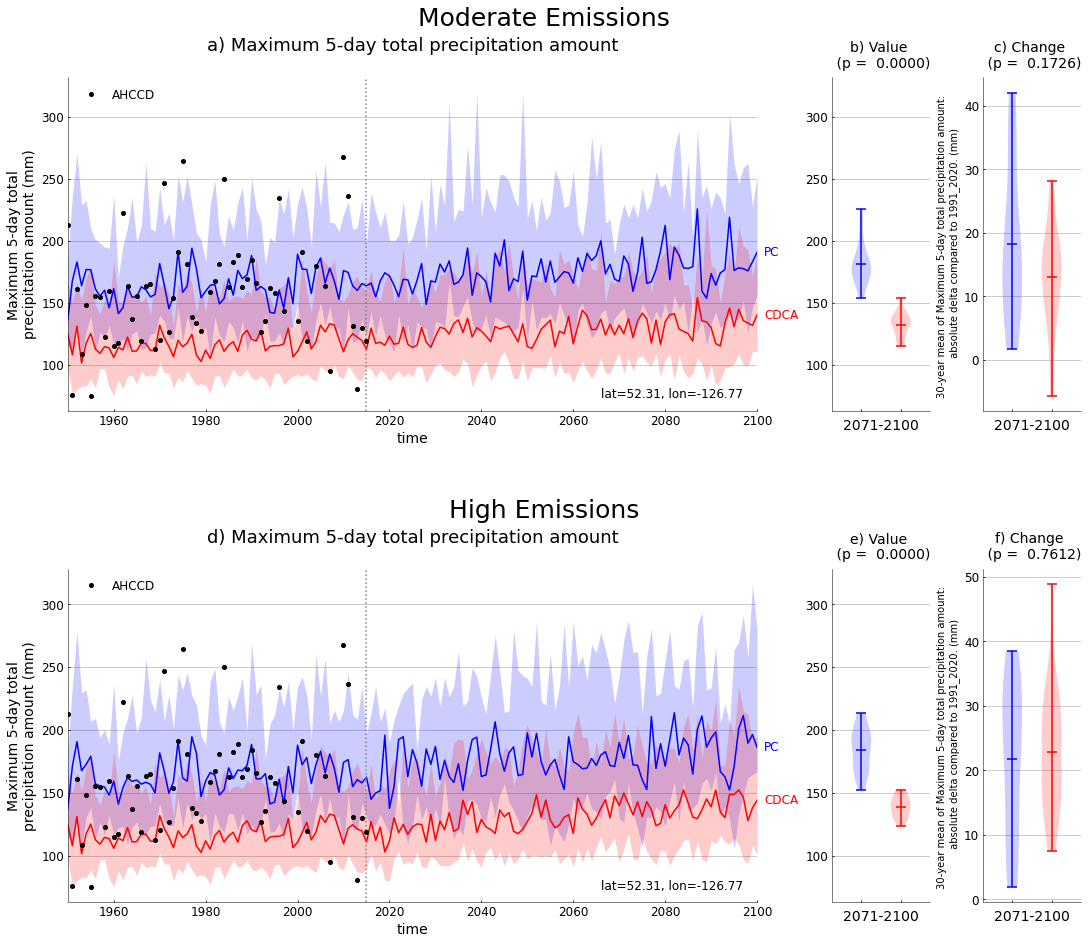

In [10]:

fig, axs = cs_plot(
    var_pc='rx5day', var_cd='rx5day',
    xrfreq='AS-JAN',
    lat=52.366665, lon=    -126.749997 # Firvale, British Columbia
                   )


lat=52.366665
lon=    -126.749997
var_pc='rx5day'
var_cd='rx5day'
xrfreq='AS-JAN'
station_cat = xs.DataCatalog('/tank/scenario/catalogues/station-obs.json')
ds_sta=station_cat.search(source='AHCCD', variable='pr').to_dataset()
ds_sta = xs.spatial.subset(ds_sta,region=dict(method='gridpoint',
                                            name='single_point',
                                            gridpoint =dict(lat=[lat], lon=[lon])))

da_sta= xc.atmos.max_n_day_precipitation_amount(ds_sta['pr'], window=5, freq='YS').sel(time=slice('1950',None))
axs[0][0].plot(da_sta.time, da_sta.values,label='AHCCD', linestyle='none', color='black', marker='.', markersize=8)
axs[1][0].plot(da_sta.time, da_sta.values,label='AHCCD', linestyle='none', color='black', marker='.', markersize=8)

lines = axs[0][0].get_lines()[-1:]
axs[0][0].legend(lines, [l.get_label() for l in lines], loc='upper left')
axs[1][0].legend(lines, [l.get_label() for l in lines], loc='upper left')
print(da_sta.station_name.values, da_sta.stnid.values, ds_sta.lat.values, ds_sta.lon.values)
plt.savefig(f"{CONFIG['paths']['figures']}rain.pdf", bbox_inches='tight')

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.


pc 0.19483839184959434
cdca 0.00978160183745564


<AxesSubplot:title={'center':' \n PC vs AHCCD (p =  0.1449)\n CDCA vs AHCCD (p =  0.0098)'}, xlabel='1991-2020', ylabel='Maximum 5-day total precipitation amount (mm)'>

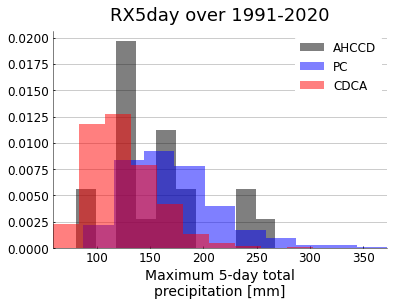

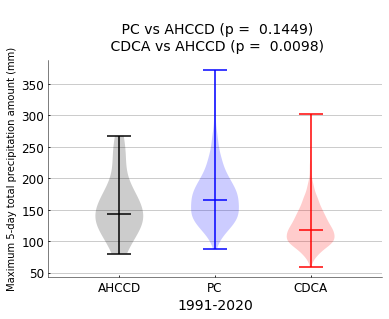

In [11]:
# compare distributions
lat=52.366665
lon=    -126.749997
var_pc='rx5day'
var_cd='rx5day'
xrfreq='AS-JAN'
#ahccd
station_cat = xs.DataCatalog('/tank/scenario/catalogues/station-obs.json')
ds_sta=station_cat.search(source='AHCCD', variable='pr').to_dataset()
ds_sta = xs.spatial.subset(ds_sta,region=dict(method='gridpoint',
                                            name='single_point',
                                            gridpoint =dict(lat=[lat], lon=[lon])))

da_sta= xc.atmos.max_n_day_precipitation_amount(ds_sta['pr'], window=5, freq='YS').sel(time=slice('1991','2020'))

da_sta.plot.hist(label='AHCCD', alpha=0.5, density=True, color='black')


#espo
ds_pc=pcat_espo.search(variable=var_pc,
                processing_level='indicators',
                xrfreq=xrfreq,
                 domain='NAM-rdrs',
                 source=sources_hausfather,
                experiment='ssp245').to_dataset(create_ensemble_on=['institution','source', 'member'],**tdd)

ds_pc= xs.spatial.subset(ds_pc,region=dict(method='gridpoint',
                                        name='single_point',
                                        gridpoint =dict(lat=[lat], lon=[lon]))).sel(time=slice('1991','2020')).rx5day


ds_pc.plot.hist(label='PC', alpha=0.5, density=True, color='blue')

#pcic
ds_cd=pcat.search(variable=var_cd,
                processing_level='indicators',
                xrfreq=xrfreq,
                experiment='ssp245').to_dataset(create_ensemble_on=['source', 'member'],**tdd)

ds_cd= xs.spatial.subset(ds_cd,region=dict(method='gridpoint',
                                        name='single_point',
                                        gridpoint =dict(lat=[lat], lon=[lon]))).sel(time=slice('1991','2020')).rx5day


ds_cd.plot.hist(label='CDCA', alpha=0.5, density=True, color='red')
plt.legend()
plt.title('RX5day over 1991-2020')


print('pc',get_pvalue(da_sta.values, np.ravel(ds_pc.values)))
print('cdca',get_pvalue(da_sta.values, np.ravel(ds_cd.values)))

def violin_dist(ax, group1, group2, group3, xticks=["",""], xlabel="", ylabel="", title=""):
    
    
    parts=ax.violinplot([group1],positions=[1],showmedians=True)
    parts2=ax.violinplot([ group2],positions=[2],showmedians=True)
    parts3=ax.violinplot([ group3],positions=[3],showmedians=True)
    def set_axis_style(ax, xticks):
        ax.set_xticks(np.arange(1, len(xticks) + 1), labels=xticks)
        ax.set_xlim(0.25, len(xticks) + 0.75)
    set_axis_style(ax, xticks)

    for pc in parts['bodies']:
        pc.set_facecolor('k')
        pc.set_alpha(0.2)
    for pc in parts2['bodies']:
        pc.set_facecolor('b')
        pc.set_alpha(0.2)
    for pc in parts3['bodies']:
        pc.set_facecolor('r')
        pc.set_alpha(0.2)
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = parts2[partname]
        vp.set_edgecolor('b')
        vp = parts[partname]
        vp.set_edgecolor('k')
        vp = parts3[partname]
        vp.set_edgecolor('r')

    maxi=np.max([ax.get_ylim()[1]])
    pvalue2=get_pvalue(group1, group2)
    pvalue3=get_pvalue(group1, group3)
    
    #ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_title(f"{title} \n PC vs AHCCD (p =  %.4f)\n CDCA vs AHCCD (p =  %.4f)" % (pvalue2,pvalue3), fontsize=14)
    ax.set_ylabel(ylabel.replace(':', ': \n'), fontsize=10)
    return ax
plt.figure()
ax=plt.axes()
violin_dist(ax, [x for x in da_sta.values if ~np.isnan(x)], list(np.ravel(ds_pc.values)),list(np.ravel(ds_cd.values)),
       ylabel="Maximum 5-day total precipitation amount (mm)",
       xticks=['AHCCD', 'PC','CDCA'], xlabel='1991-2020',
               title=f'')


In [101]:
# check how many statio inside range.
var_pc='rx5day'
var_cd='rx5day'
xrfreq='AS-JAN'
ds_pc = pcat_espo.search(processing_level='ensemble-indicators',
                                 bias_adjust_project='ESPO-G6',
                                 experiment='ssp245',
                                 domain='NAM-rdrs',
                                variable = [var_pc+p for p in ['_p10','_p50','_p90']],
                                xrfreq=xrfreq,
                            ).to_dask(**tdd)
# select lat lon on rlat rlon
ds_pc = xs.spatial.subset(ds_pc,region=dict(method='gridpoint',
                                            name='single_point',
                                            gridpoint =dict(lat=[lat], lon=[lon])))

inside_pc =[s for s, p10, p90 in zip(da_sta.values, ds_pc.rx5day_p10, ds_pc.rx5day_p90) if (p10<=s<=p90)]
#climate data
ds_cd = pcat.search(processing_level='ensemble-indicators',
                    bias_adjust_project='climatedata',
                    experiment='ssp245',
                    variable = [var_cd+p for p in ['_p10','_p50','_p90']],
                    xrfreq=xrfreq,

           ).to_dask(**tdd).sel(lat=lat, lon=lon, method='nearest')

inside_cd =[s for s, p10, p90 in zip(da_sta.values, ds_cd.rx5day_p10, ds_cd.rx5day_p90) if (p10<=s<=p90)]
print('PC',len(inside_pc))
print('CDCA',len(inside_cd))

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.


PC 37
CDCA 28


## 5. Building and Health in heat

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
0


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
0


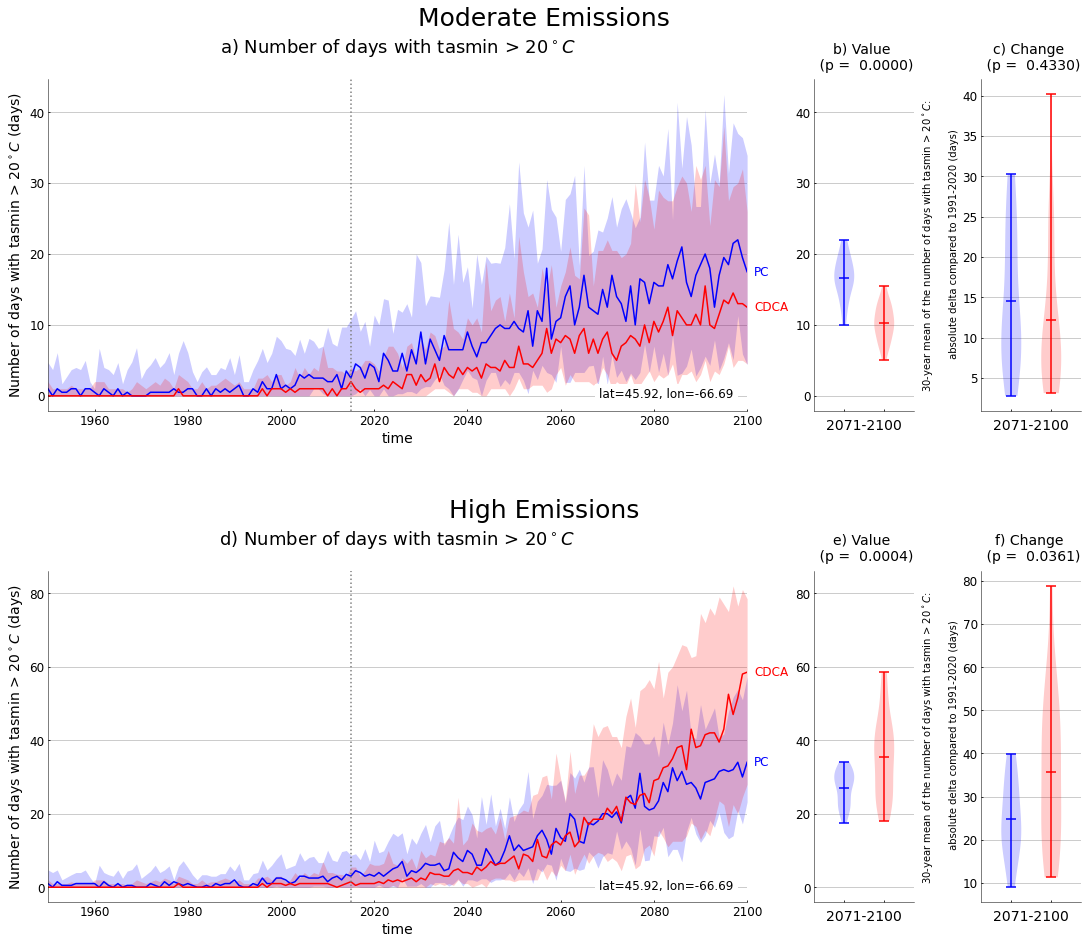

In [14]:
fig, axs = cs_plot(
    var_pc='tn_days_above_20', var_cd='tr_20',
    xrfreq='AS-JAN',
    lat=45.945278, lon=  -66.666667, # Fredericton, New-Brunswick
    #lat=49.2827, lon=  -123.1207, #Vancouver
    ylabel=r'Number of days with tasmin > 20$^\circ C$ (days)',
    delta_ylabel=r'30-year mean of the number of days with tasmin > 20$^\circ C$:'+'\n absolute delta compared to 1991-2020 (days)'
                       )
plt.savefig(f"{CONFIG['paths']['figures']}tn_20.pdf", bbox_inches='tight')    

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
0


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
0


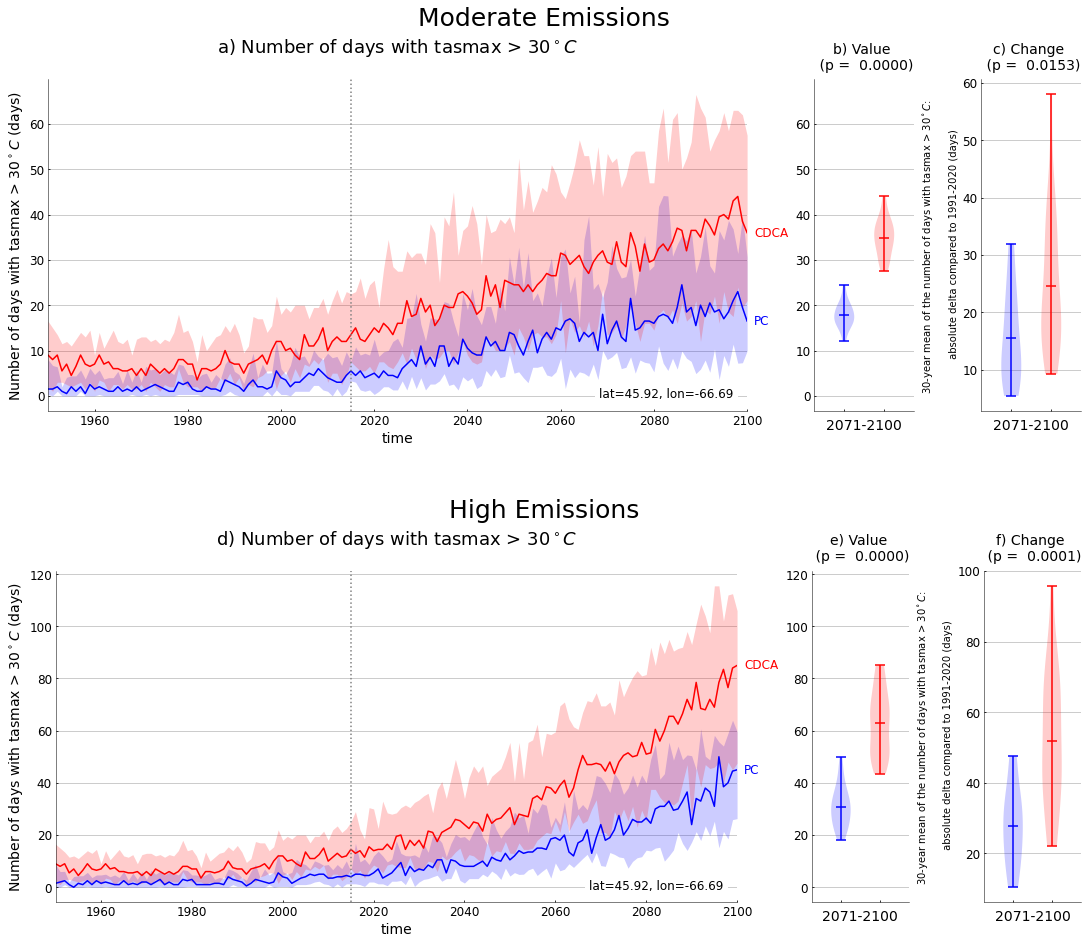

In [15]:
fig, axs = cs_plot(
    var_pc='tx_days_above_30', var_cd='txgt_30',
    xrfreq='AS-JAN',
    lat=45.945278, lon=  -66.666667, # Fredericton, New-Brunswick
    ylabel=r'Number of days with tasmax > 30$^\circ C$ (days)',
    delta_ylabel=r'30-year mean of the number of days with tasmax > 30$^\circ C$:'+'\n absolute delta compared to 1991-2020 (days)',
                   )
plt.savefig(f"{CONFIG['paths']['figures']}tx_30.pdf", bbox_inches='tight')

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
0


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: UserWarning: Loading longitude and latitude for more efficient subsetting.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xscen/spatial.py:160: User

Number of PC delta < 0
0
Number of CD delta < 0
0


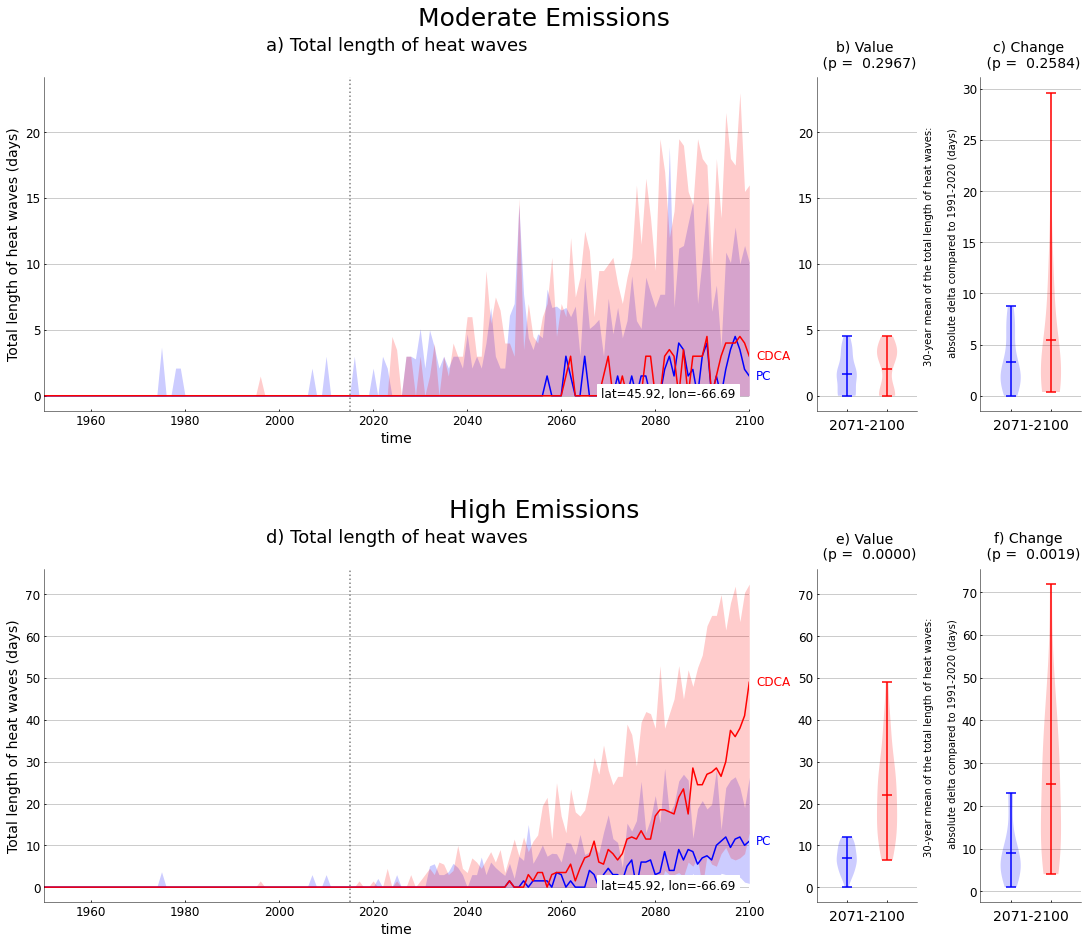

In [16]:
fig, axs = cs_plot(
    var_pc='heat_wave_total_length_20_30', var_cd='heat_wave_total_length_20_30',
    xrfreq='AS-JAN',
    lat=45.945278, lon=  -66.666667, # Fredericton, New-Brunswick
    ylabel=r'Total length of heat waves (days)',
    delta_ylabel=r'30-year mean of the total length of heat waves:'+'\n absolute delta compared to 1991-2020 (days)',
                   )
plt.savefig(f"{CONFIG['paths']['figures']}lenheat.pdf", bbox_inches='tight')

# map

ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db


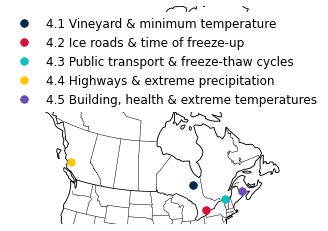

In [3]:
import cartopy.feature as cfeature
lats=[49.7189,43.6777,45.133331,52.366665,45.945278]
lons=[-82.3562,-79.6248 , -72.800003, -126.749997, -66.666667,]
# country boundaries
resol = '50m'
country_bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', edgecolor='k')

# province boundaries
provinc_bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')

land = cfeature.NaturalEarthFeature('physical', 'coastline', '110m', facecolor='none', edgecolor='k')

ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-131,-54, 41.5, 82.4], crs =ccrs.PlateCarree())
for lo, la, le in zip(lons,lats, [
    '4.1 Vineyard & minimum temperature',
    '4.2 Ice roads & time of freeze-up',
    '4.3 Public transport & freeze-thaw cycles',
    '4.4 Highways & extreme precipitation',
    '4.5 Building, health & extreme temperatures' ]):
    ax.plot([lo],[la], transform =ccrs.PlateCarree(), marker='.' ,markersize=15, linestyle='none', label=le)
plt.legend(loc='upper center')
ax.add_feature(land, linewidth=0.9)
ax.add_feature(country_bodr, linewidth=0.8)
ax.add_feature(provinc_bodr, linewidth=0.5)
ax.axis('off')
plt.savefig(f"{CONFIG['paths']['figures']}map.pdf", bbox_inches='tight')